,Title,Price,Location,Link
1,"2BD 1BA, Bike Storage, In-suite laundry",3285.0,"1022 Nelson Street, Vancouver, Bc",https://vancouver.craigslist.org/van/apa/d/van...
2,"EV Parking, Mobi Bike Share Station, Storage L...",3450.0,"333 E 11Th Ave, Vancouver, Bc",https://vancouver.craigslist.org/van/apa/d/van...
3,2 bedroom basement,2100.0,North Shore,https://vancouver.craigslist.org/nvn/apa/d/nor...
4,New Suite with 2 Bedroom 2 bath in South Surrey,2800.0,Surrey,https://vancouver.craigslist.org/rds/apa/d/sur...
5,"$3,600 / 4br - Quiet 4 Bedroom 4 Bathroom town...",3600.0,Surrey,https://vancouver.craigslist.org/rds/apa/d/sur...
...,...,...,...,...
337,Studio suite with 1 Bath,1700.0,Surrey,https://vancouver.craigslist.org/rds/apa/d/sur...
338,"2B 2Ba, Condo-Style Finishes Throughout, 100% ...",2565.0,"3370 Dewdney Trunk Road, Port Moody, Bc",https://vancouver.craigslist.org/pml/apa/d/por...
339,TWO Bedroom Basement,1750.0,Surrey,https://vancouver.craigslist.org/rds/apa/d/sur...
340,Furnished 2Bd Suite - Garden Level in Upper La...,3200.0,North Shore,https://vancouver.craigslist.org/nvn/apa/d/nor...


,Price
count,341.000000
mean,2560.630499
std,828.580600
min,375.000000
25%,2000.000000
50%,2475.000000
75%,3100.000000
max,4950.000000


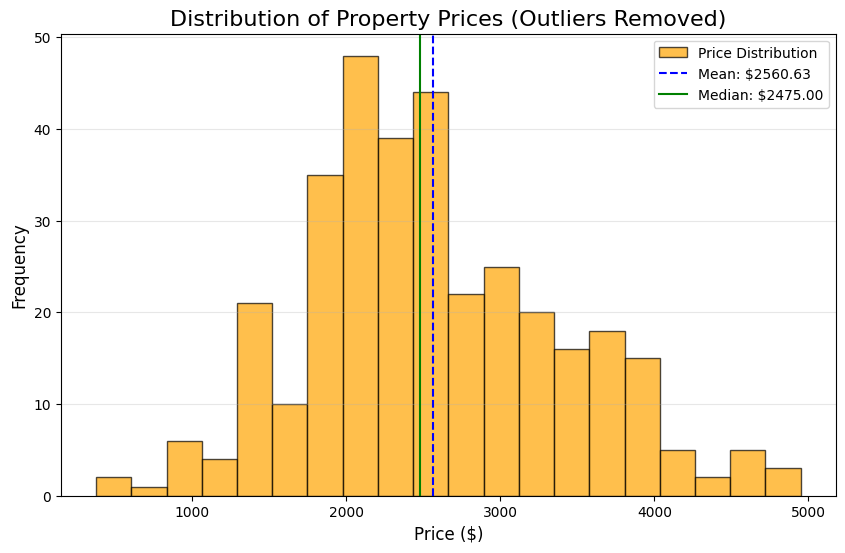

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display
import numpy as np

# URL of the Craigslist page
url = 'https://vancouver.craigslist.org/search/apa'

# Send a request to fetch the raw HTML of the page (static content)
response = requests.get(url)

# Parse the HTML
soup = BeautifulSoup(response.text, "html.parser")

# Extract the first 360 postings
postings = soup.find_all('li', class_='cl-static-search-result')[:360]

# Initialize empty lists to store title, prices, location, link
titles = []
prices = []
locations = []
links = []

# Loop through each posting and extract the title, price, location, and link
for post in postings:
    title = post.find('div', class_='title')
    if title:
        titles.append(title.text.strip())
    else:
        titles.append(None)  # Append None if title is not found

    price = post.find('div', class_='price')
    if price:
        prices.append(price.text.strip())
    else:
        prices.append(None)  # Append None if price is not found

    location = post.find('div', class_='location')
    if location:
        locations.append(location.text.strip())
    else:
        locations.append(None)  # Append None if location is not found

    link = post.find('a', class_="")
    if link:
        links.append(link["href"])
    else:
        links.append(None)  # Append None if link is not found

# Create a DataFrame from the first 360 listings
data = pd.DataFrame({
    'Title': titles,
    'Price': prices,
    'Location': locations,
    'Link': links
})

# Step 1: Check for missing values
missing_summary = data.isnull().sum()

# Step 2: Clean the Price column by removing "$" and quotes, then convert to numeric
data['Price'] = data['Price'].str.replace(r'\$', '', regex=True).str.replace(',', '', regex=True).astype(float)
# Step 3: Standardize Location names
data['Location'] = data['Location'].str.replace('"', '').str.strip().str.title()

# Step 4: Detect and handle outliers in the Price column
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
cleaned_data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]


# Step 5: Reset the index to start from 1
cleaned_data.reset_index(drop=True, inplace=True)
cleaned_data.index += 1

# Save the cleaned dataset to file and display the result
display(cleaned_data)
cleaned_data.to_csv('cleaned_craigslist_data.csv', index=False)
# Return summaries of missing values and the cleaned data description

display(cleaned_data.describe())

import matplotlib.pyplot as plt

# Recreate the histogram after confirming that the dataset excludes outliers
# Prices have already been cleaned and outliers removed in the "cleaned_data" dataframe

# Extract cleaned prices
cleaned_prices = cleaned_data['Price']

# Calculate mean and median for the cleaned dataset
mean_cleaned_price = cleaned_prices.mean()
median_cleaned_price = cleaned_prices.median()

# Create a histogram for the cleaned dataset
plt.figure(figsize=(10, 6))
plt.hist(cleaned_prices, bins=20, alpha=0.7, edgecolor='black', color='orange', label='Price Distribution')

# Add mean and median lines
plt.axvline(mean_cleaned_price, color='blue', linestyle='--', label=f'Mean: ${mean_cleaned_price:.2f}')
plt.axvline(median_cleaned_price, color='green', linestyle='-', label=f'Median: ${median_cleaned_price:.2f}')

# Add labels, title, and legend
plt.title('Distribution of Property Prices (Outliers Removed)', fontsize=16)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Display the updated plot
plt.show()

# Calculate mean and median for the cleaned dataset
mean_cleaned_price = cleaned_prices.mean()
median_cleaned_price = cleaned_prices.median()

# Determine the price range with the highest frequency (mode of the histogram)
hist, bin_edges = np.histogram(cleaned_prices, bins=20)
max_bin_index = np.argmax(hist)
price_range_mode = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])

# Create a descriptive paragraph
description = (
    f"The mean rental price of the properties, after removing outliers, is ${mean_cleaned_price:.2f}. "
    f"The median rental price is ${median_cleaned_price:.2f}. "
    f"The prices are most clustered in the range ${price_range_mode[0]:.2f} to ${price_range_mode[1]:.2f}. "
    "This indicates that the average rental price is slightly higher than the median, suggesting a right-skewed distribution."
)

# graph_description = (
#     "\nPatterns: The data reveals that as rental prices increase, the number of available properties decreases, indicating that higher-priced rentals are less common. "
#     "The mean rental price is slightly higher than the median, further supporting the observation of a right-skewed price distribution."
#     "\n\nOverall, most rental properties fall into the lower price ranges, "
#     f"with the most common configurations being {mode_beds} bedrooms and {mode_baths} bathroom. "
#     "Higher-priced rentals are rare, suggesting a premium for desirable locations or unique property features. "
#     "At the same time, the competitive nature of Vancouver's rental market for mid-range properties reflects the city's high cost of living."
# )

# Display the descriptive paragraph
print(description)